# Описание и пайплайн

Задача:

Необходимо предсказать общее количество продаж для каждой пары товар/магазин в следующем месяце.

Для решения задачи у нас есть данные за каждый день для предыдущих 34 месяцев. Нам нужно спрогнозировать общее число проданных товаров для каждого магазина в тестовом датасете. Список магазинов и товаров каждый месяц немного разные.

Количество продаж для каждого товара также варьируется в зависимости от месяца. Дополнительную информацию можно получить из других датасетов, которые представлены в соревновании.

Данные:

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date - date in format dd/mm/yyyy
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

Пайплайн:
- загрузка данных
- анализ основных данных
- поиск и удаление выбросов
- работа с остальными датасетами
- создание матрицы из всех пар товар/магазин для каждого месяца
- добавление месячных продаж (целевой переменной)
- ограничение значений целевой переменной диапазоном (0,20)
- объединение с тестовым датасетом (в тесте месяц будет следующий за последним в трейне)
- объединение с остальными датасетами
- добавление новых признаков (feature engineering)
- добавление лагов
- разбивка данных на обучающую, валидационную (последний месяц из имеющихся данных) и тестовую выборки
- тестирование LGBM, XGB, Catboost
- подбор параметров, обучение моделей и вывод важностей признаков
- bagging
- stacking

# Загрузка библиотек

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor, Pool

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import sys
import gc
import pickle
from sklearn.externals import joblib

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Загрузка и анализ данных

In [ ]:
# загрузка данных

train = pd.read_csv('/content/sales_train.csv')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
test = pd.read_csv('/content/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [ ]:
print('Train shape:', train.shape)
print('Test shape:',  test.shape)

Train shape: (2935849, 6)
Test shape: (214200, 3)


In [ ]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [ ]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [ ]:
train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64

In [ ]:
test.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [ ]:
# выведем количество дублирующихся строк

print('Number of duplicates:', len(train[train.duplicated()])) # дублей очень мало, оставим датафрейм без изменений

Number of duplicates: 6


In [ ]:
# преобразование столбца с датами

train['date'] = train['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [ ]:
# добавим столбцы год, месяц, день, день недели

train['year'] = train.date.dt.year
train['month'] = train.date.dt.month
train['day'] = train.date.dt.day
train['weekday'] = train.date.dt.weekday

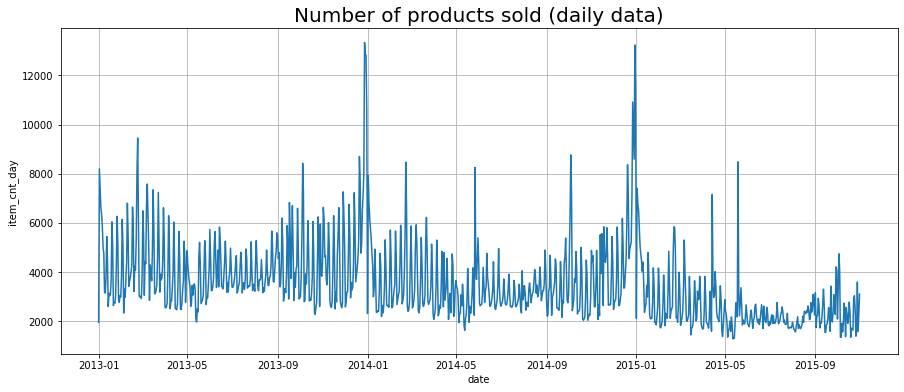

In [ ]:
# посмотрим на общее количество продаж по дням

daily_sales = pd.DataFrame(train.groupby('date')['item_cnt_day'].sum()).reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='item_cnt_day', data=daily_sales)
plt.title('Number of products sold (daily data)', fontsize=20)
plt.grid(True);

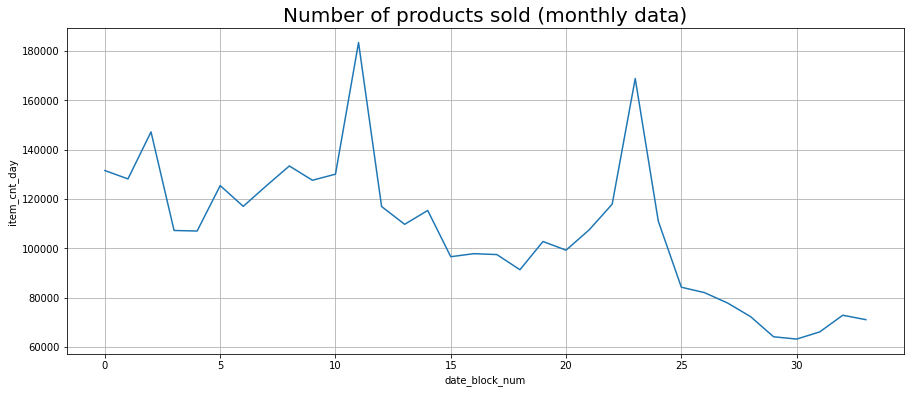

In [ ]:
# посмотрим на общее количество продаж по месяцам

monthly_sales = pd.DataFrame(train.groupby('date_block_num')['item_cnt_day'].sum()).reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='date_block_num', y='item_cnt_day', data=monthly_sales)
plt.title('Number of products sold (monthly data)', fontsize=20)
plt.grid(True);

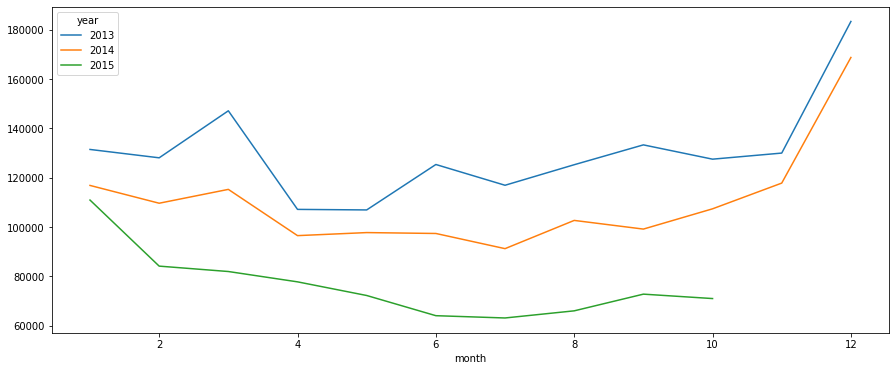

In [ ]:
# посмотрим на общее количество продаж по годам

data = train.groupby(
    ['year', 'month']).agg({'item_cnt_day': np.sum}).reset_index().pivot(
    index='month', columns='year', values='item_cnt_day')
data.plot(figsize=(15, 6));

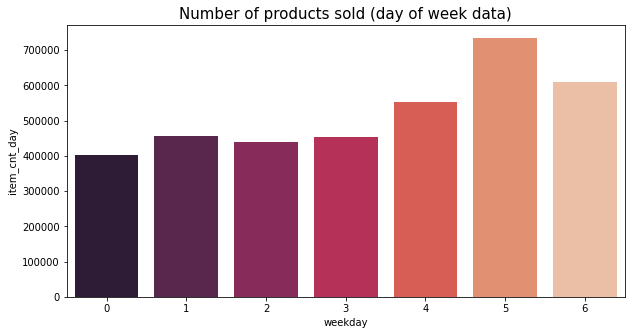

In [ ]:
# посмотрим на общее количество продаж по дням недели

weekday_sales = pd.DataFrame(train.groupby('weekday')['item_cnt_day'].sum()).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='weekday', y='item_cnt_day', data=weekday_sales, palette='rocket')
plt.title('Number of products sold (day of week data)', fontsize=15);

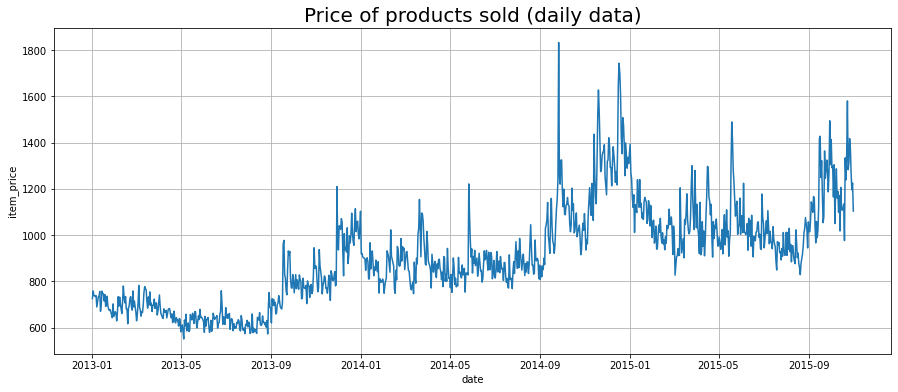

In [ ]:
# посмотрим на среднюю стоимость товаров по дням

daily_price = pd.DataFrame(train.groupby('date')['item_price'].mean()).reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='item_price', data=daily_price)
plt.title('Price of products sold (daily data)', fontsize=20)
plt.grid(True);

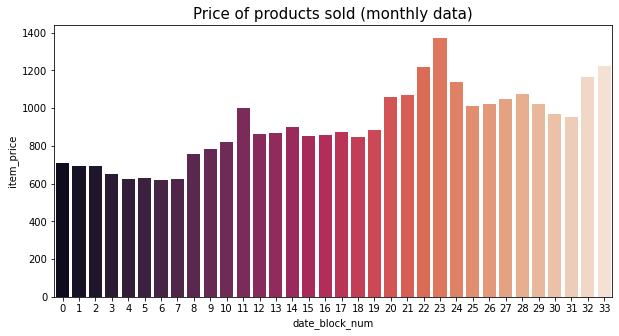

In [ ]:
# посмотрим на среднюю стоимость товаров по месяцам

monthly_price = pd.DataFrame(train.groupby('date_block_num')['item_price'].mean()).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='date_block_num', y='item_price', data=monthly_price, palette='rocket')
plt.title('Price of products sold (monthly data)', fontsize=15);

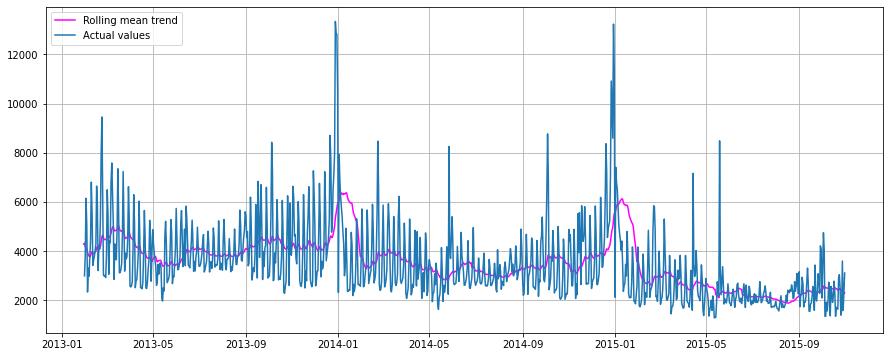

In [ ]:
# воспользуемся функцией rolling для выявления трендов
# window - количество дней, используемое для расчета статистики (чем больше ширина интервала, тем более сглаженным будет тренд)
# для наших данных тренды и так неплохо видны, но посмотрим на более сглаженную линию тренда
# сглаживаем по 30 дней

sales_per_day = train.groupby(['date'])['item_cnt_day'].sum()  

rolling_mean = sales_per_day.rolling(window=30).mean()

plt.figure(figsize=(15, 6))
plt.plot(rolling_mean, label='Rolling mean trend', color='magenta')
plt.plot(sales_per_day[30:], label='Actual values')
plt.legend(loc='upper left')
plt.grid(True);

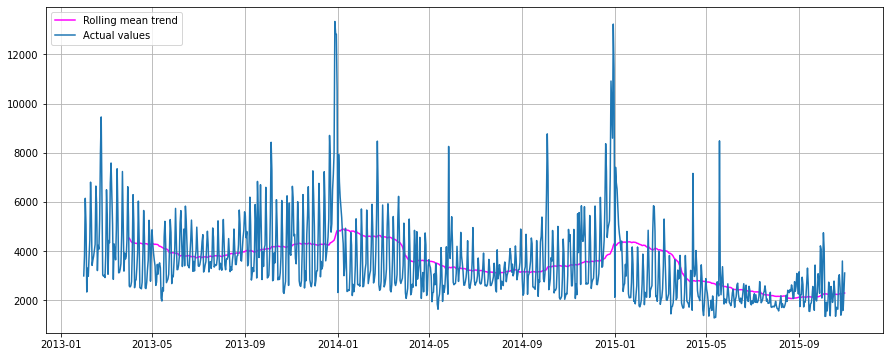

In [ ]:
# посмотрим на тренд для 90 дней

sales_per_day = train.groupby(['date'])['item_cnt_day'].sum()

rolling_mean = sales_per_day.rolling(window=90).mean()

plt.figure(figsize=(15, 6))
plt.plot(rolling_mean, label='Rolling mean trend', color='magenta')
plt.plot(sales_per_day[30:], label='Actual values')
plt.legend(loc='upper left')
plt.grid(True);

Проверим временной ряд на стационарность, т.е. способность данных не менять своих статистических характеристик с течением времени (среднее, дисперсия и т.д.). Если эти параметры со временем растут или понижаются, то ряд не стационарный.

Для проверки на стационарность будем использовать тест Дикки-Фуллера.

In [ ]:
test_df = sm.tsa.adfuller(sales_per_day)

print('adf: ', test_df[0])
print('p-value: ', test_df[1])
print('Critical values: ', test_df[4])

if test_df[0] > test_df[4]['5%']: 
    print('Ряд не стационарен')
else:
    print('Ряд стационарен')

adf:  -4.045604237566617
p-value:  0.0011896661581716364
Critical values:  {'1%': -3.436828225807217, '5%': -2.8644002004847144, '10%': -2.568292900881126}
Ряд стационарен


# Работа с выбросами

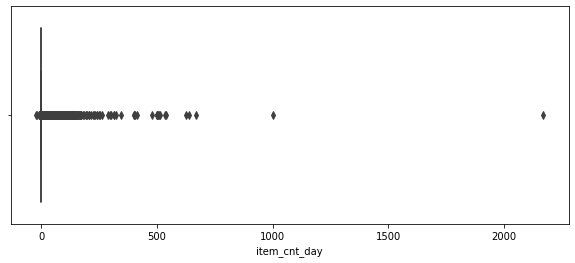

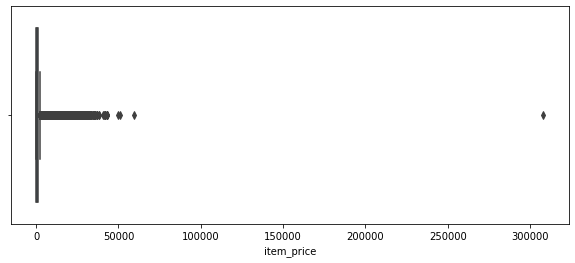

In [ ]:
# найдем выбросы в ценах и продажах

plt.figure(figsize=(10, 4))
sns.boxplot(x=train['item_cnt_day'])

plt.figure(figsize=(10, 4))
sns.boxplot(x=train['item_price']);

In [ ]:
train['item_cnt_day'].sort_values(ascending=False).head()

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

In [ ]:
train['item_price'].sort_values(ascending=False).head()

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2910156     42990.0
Name: item_price, dtype: float64

In [ ]:
# удалим товары с ценой > 300000 и продажи > 2000

train = train[train.item_price < 300000]
train = train[train.item_cnt_day < 2000]

In [ ]:
# проверим минимальные значения
# один товар имеет отрицательную стоимость

train['item_price'].sort_values().head()

484683   -1.0000
608763    0.0700
579766    0.0700
611400    0.0875
673155    0.0900
Name: item_price, dtype: float64

In [ ]:
train[train['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,weekday
484683,2013-05-15,4,32,2973,-1.0,1.0,2013,5,15,2


In [ ]:
train[(train['item_id'] == 2973) & (train['date'] == '2013-05-15')].sort_values(by='item_price').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,weekday
484683,2013-05-15,4,32,2973,-1.0,1.0,2013,5,15,2
469951,2013-05-15,4,45,2973,1249.0,1.0,2013,5,15,2
453034,2013-05-15,4,25,2973,1249.5,1.0,2013,5,15,2
469026,2013-05-15,4,46,2973,1249.5,1.0,2013,5,15,2


In [ ]:
# отрицательное значение в item_price заменим медианным за этот день

median = train[(train['item_id'] == 2973) & (train['date'] == '2013-05-15')].item_price.median()
train.loc[train['item_price'] < 0, 'item_price'] = median

train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & (train['date'] == '2013-05-15')]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,weekday
484683,2013-05-15,4,32,2973,1249.25,1.0,2013,5,15,2


In [ ]:
# добавим данные по выручке

train['revenue'] = train['item_price'] *  train['item_cnt_day']

# Остальные датасеты

In [ ]:
# загрузим датасет shops

shops = pd.read_csv('/content/shops.csv')
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [ ]:
# часть названий в этом датасете дублируется, выведем их

shops[(shops['shop_name'].str.contains('Якутск')) | (shops['shop_name'].str.contains('Жуковский'))]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


In [ ]:
# заменим дубли на оригинальные названия

shops.shop_name[shops.shop_name == '!Якутск Орджоникидзе, 56 фран'] = 'Якутск Орджоникидзе, 56'
shops.shop_name[shops.shop_name == '!Якутск ТЦ "Центральный" фран'] = 'Якутск ТЦ "Центральный"'
shops.shop_name[shops.shop_name == 'Жуковский ул. Чкалова 39м?'] = 'Жуковский ул. Чкалова 39м²'

shops.shop_id[shops.shop_id == 0] = 57
shops.shop_id[shops.shop_id == 1] = 58
shops.shop_id[shops.shop_id == 10] = 11

# заменим неверные id в трейне и тесте

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [ ]:
# столбец shop_name содержит название города, в котором расположен магазин

shops.shop_name.unique()[:10]

array(['Якутск Орджоникидзе, 56', 'Якутск ТЦ "Центральный"',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля'], dtype=object)

In [ ]:
# выделим название города в отдельный столбец и закодируем с помощью LabelEncoder

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']].sort_values(by='shop_id')
shops.drop_duplicates(inplace=True)

In [ ]:
shops.head()

,shop_id,city_code
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4


In [ ]:
# загрузим датасет item_categories

item_categories = pd.read_csv('/content/item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [ ]:
# каждая категория содержит данные о типе и подтипе товара
# выделим их в отдельные столбцы

item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

# закодируем новые признаки с помощью LabelEncoder

item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [ ]:
# загрузим датасет items

items = pd.read_csv('/content/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
# оставим только item_id и item_category_id

items.drop(['item_name'], axis=1, inplace=True)

In [ ]:
# посмотрим на данные в тестовом датасете
# общее количество строк 214200 = 42 * 5100, таким образом, тестовый датасет состоит из всех возможных комбинаций shop_id и item_id
# нам нужно привести тренировочные данные к такому же виду, т.е. создать комбинации из date_block_num, shop_id и item_id

test.shop_id.nunique(), test.item_id.nunique(), len(test)

(42, 5100, 214200)

In [ ]:
# для каждого месяца создадим набор из всех комбинаций shop_id/item_id для данного месяца
# возьмем только id, которые присутствуют в тесте

test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

train_rd = train[train['shop_id'].isin(test_shop_ids)]
train_rd = train_rd[train_rd['item_id'].isin(test_item_ids)]

cols = ['shop_id', 'item_id', 'date_block_num']

new_set = []
for block_num in train['date_block_num'].unique():
    all_shops = train_rd[train_rd['date_block_num']==block_num]['shop_id'].unique()
    all_items = train_rd[train_rd['date_block_num']==block_num]['item_id'].unique()
    new_set.append(np.array(list(product(*[all_shops, all_items, [block_num]])), dtype='int32'))

# обернем созданный набор в pandas dataframe

new_set = pd.DataFrame(np.vstack(new_set), columns=cols)
new_set['date_block_num'] = new_set['date_block_num'].astype(np.int8)
new_set['shop_id'] = new_set['shop_id'].astype(np.int8)
new_set['item_id'] = new_set['item_id'].astype(np.int16)

new_set.sort_values(cols, inplace=True)

In [ ]:
# сгруппируем данные по shop_id/item_id/month для получения целевой переменной (количество продаж в месяц)

group = pd.DataFrame(train.groupby(cols, as_index=False).agg({'item_cnt_day': 'sum'}))
group.columns = ['shop_id', 'item_id', 'date_block_num', 'item_cnt_month']

In [ ]:
# присоединим сгруппированные данные к предыдущему набору

df = pd.merge(new_set, group, how='left', on=cols)

# в правилах для расчета оценки в этом соревновании указано, что значения y_true в тесте ограничены диапазоном [0,20]
# таким образом, то же самое нужно сделать и с y_train для получения схожих данных

df['item_cnt_month'] = (df['item_cnt_month']
                        .fillna(0)
                        .clip(0,20)
                        .astype(np.float16))

In [ ]:
# объединим все датасеты
# обозначим месяц в тесте следующим значением, которым заканчивается трейн

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
df = pd.concat([df, test.drop(['ID'], axis = 1)], ignore_index=True, sort=False, keys=cols)
df.fillna(0, inplace=True)

# объединим с остальными фреймами

df = pd.merge(df, shops, on=['shop_id'], how='left')
df = pd.merge(df, items, on=['item_id'], how='left')
df = pd.merge(df, item_categories, on=['item_category_id'], how='left')

df['city_code'] = df['city_code'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['type_code'] = df['type_code'].astype(np.int8)
df['subtype_code'] = df['subtype_code'].astype(np.int8)

df.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,2,30,1,0.0,0,40,11,4
1,2,30,2,1.0,0,40,11,4
2,2,30,3,0.0,0,40,11,4
3,2,30,4,0.0,0,40,11,4
4,2,30,5,1.0,0,40,11,4


# Feature engineering

In [ ]:
# добавим месяц

df['month'] = df['date_block_num'] % 12 + 1

In [ ]:
# у нас есть несколько выбросов по продажам в некоторые дни

item_cnt_by_date = pd.DataFrame(train.groupby('date')['item_cnt_day'].sum()).reset_index()
item_cnt_by_date = item_cnt_by_date[item_cnt_by_date['item_cnt_day'] > 10000].sort_values(by='item_cnt_day', ascending=False)
item_cnt_by_date

,date,item_cnt_day
361,2013-12-28,13343.0
728,2014-12-30,13236.0
362,2013-12-29,12863.0
363,2013-12-30,12823.0
729,2014-12-31,11394.0
725,2014-12-27,10919.0
364,2013-12-31,10514.0


In [ ]:
# из таблицы видно, что наибольшее число продаж приходится на последние несколько дней перед новым годом
# посмотрим, какие месяцы из date_block_num относятся к 12 месяцу в month

month = train[['date_block_num', 'month']][train['month'] == 12]
month.drop_duplicates()

,date_block_num,month
1124316,11,12
2192637,23,12


In [ ]:
# добавим признак для обозначения есть ли в данном месяце такие дни

df['new_year_month'] = df['date_block_num'].map(str)
dct = {'11': 1, '23': 1}
df['new_year_month'] = df['new_year_month'].map(dct)
df['new_year_month'].fillna(0, inplace=True)

In [ ]:
# количество продаж также зависит от количества дней в данном месяце
# добавим такой признак

group = pd.DataFrame(train.groupby('date_block_num').agg({'date': [np.min, np.max]}))
group.columns = ['min_month_date', 'max_month_date']
group.reset_index(inplace=True)

group['days_in_month'] = (group.max_month_date - group.min_month_date)
group['days_in_month'] = group['days_in_month'].dt.days.astype('int16') + 1

df = pd.merge(df, group, on='date_block_num', how='left')
df.drop(['min_month_date', 'max_month_date'], axis=1, inplace=True)

In [ ]:
# из графиков видно, что число продаж вырастает в выходные дни
# добавим признак с количеством выходных дней в данном месяце

group = pd.DataFrame(train.groupby(['date_block_num', 'date'])['weekday'].sum())
group.reset_index(inplace=True)

group['day_of_week'] = group.date.dt.weekday
group = pd.DataFrame(group.groupby(['date_block_num', 'day_of_week']).agg({'weekday': 'count'}))
group.reset_index(inplace=True)
group.columns = ['date_block_num', 'day_of_week', 'day_of_week_in_month']

group = group[(group['day_of_week'] == 5) | (group['day_of_week'] == 6)]

group = pd.DataFrame(group.groupby(['date_block_num'])['day_of_week_in_month'].sum())
group.reset_index(inplace=True)
group.columns = ['date_block_num', 'weekdays_in_month']

df = pd.merge(df, group, on='date_block_num', how='left')

In [ ]:
# выведем последнюю дату в датафрейме, чтобы использовать это для следующего месяца в тесте

train.sort_values(by='date').tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,weekday,revenue
2916534,2015-10-31,33,2,13337,599.0,1.0,2015,10,31,5,599.0
2932051,2015-10-31,33,21,4261,299.0,1.0,2015,10,31,5,299.0
2893639,2015-10-31,33,35,20304,699.0,1.0,2015,10,31,5,699.0
2907409,2015-10-31,33,52,4351,399.0,1.0,2015,10,31,5,399.0
2901304,2015-10-31,33,48,8546,1299.0,1.0,2015,10,31,5,1299.0


In [ ]:
# для 34-го месяца в тесте добавим данные вручную

df.days_in_month[df['date_block_num'] == 34] = 30
df.weekdays_in_month[df['date_block_num'] == 34] = 9

df['new_year_month'] = df['new_year_month'].astype(np.int8)
df['days_in_month'] = df['days_in_month'].astype(np.int8)
df['weekdays_in_month'] = df['weekdays_in_month'].astype(np.int8)

In [ ]:
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,type_code,subtype_code,month,new_year_month,days_in_month,weekdays_in_month
0,2,30,1,0.0,0,40,11,4,2,0,28,8
1,2,30,2,1.0,0,40,11,4,3,0,31,10
2,2,30,3,0.0,0,40,11,4,4,0,30,8
3,2,30,4,0.0,0,40,11,4,5,0,31,8
4,2,30,5,1.0,0,40,11,4,6,0,30,10


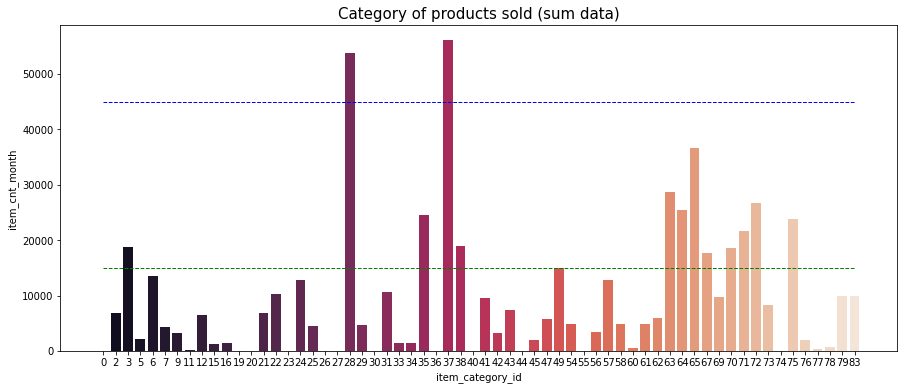

In [ ]:
# посмотрим на продажи по категориям

item_cnt_category_sum = df.groupby(['item_category_id'])['item_cnt_month'].sum().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='item_category_id', y='item_cnt_month', data=item_cnt_category_sum, palette='rocket', ax=ax)
plt.title('Category of products sold (sum data)', fontsize=15)
ax.hlines(45000, 0, 61,
          color='b',
          linewidth=1,
          linestyle='--')
ax.hlines(15000, 0, 61,
          color='g',
          linewidth=1,
          linestyle='--');

In [ ]:
# продажи по категориям можно разделить на 3: большие, средние и маленькие
# добавим признак для обозначения популярности категории товара

df['item_category_pop'] = df['item_category_id'].map(str)
dct = {'28': 2, '37': 2, '3': 1, '35': 1, '38': 1, '63': 1, '64': 1, '65': 1, '67': 1, '70': 1, '71': 1, '72': 1, '75': 1}
df['item_category_pop'] = df['item_category_pop'].map(dct)
df['item_category_pop'].fillna(0, inplace=True)

df['item_category_pop'] = df['item_category_pop'].astype(np.int8)

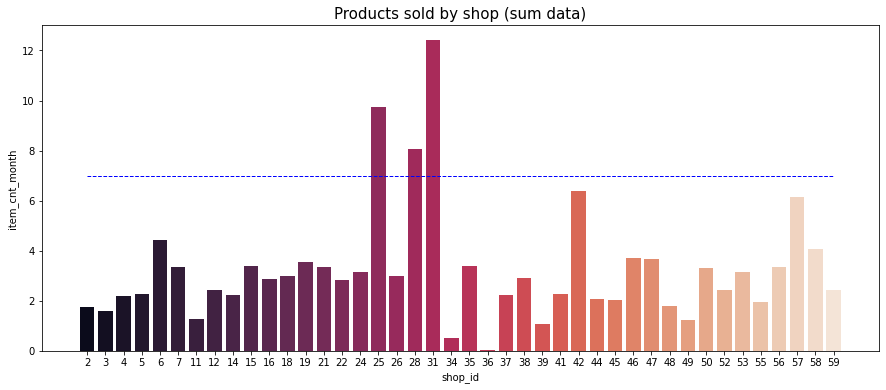

In [ ]:
# посмотрим на продажи по магазинам

item_cnt_shop_sum = df[['shop_id', 'item_cnt_month']]
item_cnt_shop_sum['item_cnt_month'] = item_cnt_shop_sum['item_cnt_month'] / 10000
item_cnt_shop_sum = item_cnt_shop_sum.groupby(['shop_id'])['item_cnt_month' ].sum().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='shop_id', y='item_cnt_month', data=item_cnt_shop_sum, palette='rocket', ax=ax)
plt.title('Products sold by shop (sum data)', fontsize=15)
ax.hlines(7, 0, 41,
          color='b',
          linewidth=1,
          linestyle='--');

In [ ]:
# у большинства магазинов примерно одинаковые суммарные продажи в месяц, но у 3-х из них продажи значительно выше остальных
# это может говорить о размерах магазина, например, это могут быть крупные гипермаркеты
# добавим признак для обозначения размера магазина

df['shop_size'] = df['shop_id'].map(str)
dct = {'25': 1, '28': 1, '31': 1}
df['shop_size'] = df['shop_size'].map(dct)
df['shop_size'].fillna(0, inplace=True)

df['shop_size'] = df['shop_size'].astype(np.int8)

In [ ]:
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,type_code,subtype_code,month,new_year_month,days_in_month,weekdays_in_month,item_category_pop,shop_size
0,2,30,1,0.0,0,40,11,4,2,0,28,8,0,0
1,2,30,2,1.0,0,40,11,4,3,0,31,10,0,0
2,2,30,3,0.0,0,40,11,4,4,0,30,8,0,0
3,2,30,4,0.0,0,40,11,4,5,0,31,8,0,0
4,2,30,5,1.0,0,40,11,4,6,0,30,10,0,0


In [ ]:
# часть магазинов представлена в датасете, начиная не с 1-го месяца
# добавим признак с указанием количества месяцев с появления магазина в каталоге

shop_min_month = df[['date_block_num', 'shop_id']].groupby('shop_id')['date_block_num'].min()
df['shop_total_months'] = df['date_block_num'] - df['shop_id'].map(shop_min_month)

# добавим признак с указанием количества месяцев с появления товара в каталоге

item_min_month = df[['date_block_num', 'item_id']].groupby('item_id')['date_block_num'].min()
df['item_total_months'] = df['date_block_num'] - df['item_id'].map(item_min_month)

# добавим признак с указанием месяца, когда товар впервые был продан

item_1_month = df[['date_block_num', 'item_id']].groupby('item_id')['date_block_num'].min()
df['item_month_release'] = df['item_id'].map(item_1_month)

# добавим признак с указанием новый ли это товар

df['item_new'] = (df['item_total_months']==0)
dct = {True: 0, False: 1}
df['item_new'] = df['item_new'].map(dct)

# добавим признак с указанием месяца, когда товар впервые был продан в данном магазине

shop_item_1_month = pd.DataFrame(df[['date_block_num', 'shop_id', 'item_id']].groupby(['shop_id', 'item_id'])['date_block_num'].min())
shop_item_1_month.reset_index(inplace=True)
shop_item_1_month.columns = ['shop_id', 'item_id', 'shop_item_month_release']
df = pd.merge(df, shop_item_1_month, on=['shop_id', 'item_id'], how='left')

# добавим признак с указанием количества месяцев с появления товара в каталоге данного магазина

df['shop_item_total_months'] = (df['date_block_num'] - df['shop_item_month_release'])

# добавим признак с указанием были продажи товара в данном магазине ранее или нет

df['item_sold_in_shop_before'] = ~(df['shop_item_total_months'] > 0)
dct = {True: 0, False: 1}
df['item_sold_in_shop_before'] = df['item_sold_in_shop_before'].map(dct)

df['shop_total_months'] = df['shop_total_months'].astype(np.int8)
df['item_total_months'] = df['item_total_months'].astype(np.int8)
df['item_month_release'] = df['item_month_release'].astype(np.int8)
df['item_new'] = df['item_new'].astype(np.int8)
df['shop_item_total_months'] = df['shop_item_total_months'].astype(np.int8)
df['item_sold_in_shop_before'] = df['item_sold_in_shop_before'].astype(np.int8)

In [ ]:
# посмотрим на регулярность продаж
# создадим таблицу, в которой столбцами будут данные из date_block_num
# запишем в нее количество проданных товаров за месяц с учетом их item_id

sales_by_item_id = train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                     columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

sales_by_item_id.head()

,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# посмотрим, есть ли товары, для которых не было продаж за весь период

sales_cols = sales_by_item_id.drop(['item_id'], axis=1).columns
total = 0
for col in sales_cols:
  total = total + sales_by_item_id[col]

sales_by_item_id['total'] = total
sales_by_item_id.sort_values(by='total').head(10)

,item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,total
1552,1590,-12,1,1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-11
13222,13474,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
11663,11871,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
17759,18062,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
13225,13477,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4504,4591,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7400,7547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8349,8515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7027,7174,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7020,7167,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# из таблицы видно, что часть товаров продается не каждый месяц
# добавим в датафрейм признак с количеством месяцев с последней продажи для каждого item_id

# значения id, для которых не было продаж или были только возвраты, удалим

sales_by_item_id.drop([1552, 13222, 11663, 17759, 13225, 4504, 7400, 8349], axis=0, inplace=True)

# поменяем порядок месяцев на обратный, а в качестве столбцов будем использовать item_id

cols_inv = sales_by_item_id.columns.tolist()
cols_inv = cols_inv[::-1]
sales_by_item_id_inv = sales_by_item_id[cols_inv]

sales_by_item_id_inv = sales_by_item_id_inv.T

# создадим список с количеством месяцев с последней продажи

cols = sales_by_item_id_inv.columns
last_sales_by_item_id = []
for col in cols:
  count = 0
  for i in sales_by_item_id_inv.drop(['item_id', 'total'], axis=0)[col]:
    if i == 0:
      count += 1
    else:
      last_sales_by_item_id.append(count)
      break

# создадим новый датафрейм

last_sales_months = pd.DataFrame({'item_id': sales_by_item_id['item_id'],
                                  'month_last_sales': last_sales_by_item_id})

last_sales_months['item_id'] = last_sales_months['item_id'].astype(np.int16)
last_sales_months['month_last_sales'] = last_sales_months['month_last_sales'].astype(np.int16)

In [ ]:
# добавим новый признак в основной датафрейм

df = pd.merge(df, last_sales_months, on=['item_id'], how='left')
df.fillna(0, inplace=True)
df['month_last_sales'] = df['month_last_sales'].astype(np.int8)

df.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,type_code,subtype_code,month,new_year_month,days_in_month,weekdays_in_month,item_category_pop,shop_size,shop_total_months,item_total_months,item_month_release,item_new,shop_item_month_release,shop_item_total_months,item_sold_in_shop_before,month_last_sales
0,2,30,1,0.0,0,40,11,4,2,0,28,8,0,0,1,0,1,0,1,0,0,0
1,2,30,2,1.0,0,40,11,4,3,0,31,10,0,0,2,1,1,1,1,1,1,0
2,2,30,3,0.0,0,40,11,4,4,0,30,8,0,0,3,2,1,1,1,2,1,0
3,2,30,4,0.0,0,40,11,4,5,0,31,8,0,0,4,3,1,1,1,3,1,0
4,2,30,5,1.0,0,40,11,4,6,0,30,10,0,0,5,4,1,1,1,4,1,0


# Lags of time series

Сдвигая ряд на $n$ шагов назад (например, на один месяц), мы получаем признак, в котором текущее значение временного ряда совпадает со значением в момент времени $t − n$. Если мы сделаем сдвиг на 1 лаг и обучим модель, то сможем прогнозировать на 1 шаг вперед от текущего наблюдения.

Сделаем это с помощью функции Pandas shift().

In [ ]:
# напишем функцию с помощью которой будем рассчитывать новые значения

def lagged_feat(data, lag_list, feat):
    for lag in lag_list:
      ft_name = (feat+'_lag_'+str(lag))
      data[ft_name] = data.groupby(['shop_id', 'item_id'])[feat].shift(lag)
      lag += 1
      data[ft_name].fillna(0, inplace=True)
    return data

In [ ]:
# добавим новые признаки, для которых будем считать лаги
# добавим количество месяцев, в которые были продажи

group_item = train.groupby(['item_id', 'date_block_num'])
group = pd.DataFrame(group_item.mean().groupby('item_id').cumcount(), columns=['item_active_months'])
group = group.reset_index()
df = pd.merge(df, group, on=['date_block_num', 'item_id'], how='left')

group_shop_item = train.groupby(['item_id', 'shop_id', 'date_block_num'])
group = pd.DataFrame(group_shop_item.mean().groupby(['shop_id','item_id']).cumcount(), columns=['shop_item_active_months'])
group = group.reset_index()
df = pd.merge(df, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')

df['item_active_months'] = df['item_active_months'].fillna(0).astype(np.int32)
df['shop_item_active_months'] = df['shop_item_active_months'].fillna(0).astype(np.int32)

In [ ]:
# добавим для каждой группы минимальную, максимальную и среднюю цены за текущий месяц

group = pd.DataFrame(train.groupby(['date_block_num', 'item_id']).agg({'item_price': [np.min, np.max, 'mean']}))
group.columns = ['min_item_price', 'max_item_price', 'avg_item_price']
group.reset_index(inplace=True)
group = group[['date_block_num', 'item_id', 'min_item_price', 'max_item_price', 'avg_item_price']]
group.drop_duplicates(inplace=True)

# добавим разницу между min и max ценами, разницу между средней ценой и min/max ценами

group['price_diff'] = group['max_item_price'] - group['min_item_price']
group['price_increase'] = group['avg_item_price'] - group['min_item_price']
group['price_decrease'] = group['max_item_price'] - group['avg_item_price']
group.drop_duplicates(inplace=True)

# объединим с основным датафреймом

df = pd.merge(df, group, on=['date_block_num', 'item_id'], how='left')
df.fillna(0, inplace=True)

df['min_item_price'] = df['min_item_price'].astype(np.float16)
df['max_item_price'] = df['max_item_price'].astype(np.float16)
df['avg_item_price'] = df['avg_item_price'].astype(np.float16)
df['price_diff'] = df['price_diff'].astype(np.float16)
df['price_increase'] = df['price_increase'].astype(np.float16)
df['price_decrease'] = df['price_decrease'].astype(np.float16)

In [ ]:
# добавим признаки на основе дохода и цены

group = pd.DataFrame(train.groupby(['item_id']).agg({'revenue': 'mean', 
                                                     'item_price': 'mean'}))
group.columns = ['item_revenue_mean', 'item_price_mean']
group.reset_index(inplace=True)
df = pd.merge(df, group, on=['item_id'], how='left')

group = pd.DataFrame(train.groupby(['date_block_num', 'item_id']).agg({'revenue': 'mean',
                                                                       'item_price': 'mean'}))
group.columns = ['item_revenue_mean_month', 'item_price_mean_month']
group.reset_index(inplace=True)
df = pd.merge(df, group, on=['date_block_num', 'item_id'], how='left')
df.fillna(0, inplace=True)

group = pd.DataFrame(train.groupby(['date_block_num', 'shop_id']).agg({'revenue': 'mean', 
                                                                       'item_price': 'mean'}))
group.columns = ['shop_revenue_mean_month', 'shop_price_mean_month']
group.reset_index(inplace=True)
df = pd.merge(df, group, on=['date_block_num', 'shop_id'], how='left')
df.fillna(0, inplace=True)

group = pd.DataFrame(train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'revenue': 'mean', 
                                                                                  'item_price': 'mean'}))
group.columns = ['shop_item_revenue_mean_month', 'shop_item_price_mean_month']
group.reset_index(inplace=True)
df = pd.merge(df, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
df.fillna(0, inplace=True)

df['item_revenue_mean'] = df['item_revenue_mean'].astype(np.float16)
df['item_price_mean'] = df['item_price_mean'].astype(np.float16)
df['item_revenue_mean_month'] = df['item_revenue_mean_month'].astype(np.float16)
df['item_price_mean_month'] = df['item_price_mean_month'].astype(np.float16)
df['shop_revenue_mean_month'] = df['item_price_mean_month'].astype(np.float16)
df['shop_price_mean_month'] = df['item_price_mean_month'].astype(np.float16)
df['shop_item_revenue_mean_month'] = df['item_price_mean_month'].astype(np.float16)
df['shop_item_price_mean_month'] = df['item_price_mean_month'].astype(np.float16)

In [ ]:
# на основе средних значений целевой переменной

df['month_avg_cnt'] = df.groupby(['date_block_num'])['item_cnt_month'].transform('mean').astype(np.float16)
df['month_item_avg_cnt'] = df.groupby(['date_block_num', 'item_id'])['item_cnt_month'].transform('mean').astype(np.float16)
df['month_shop_avg_cnt'] = df.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].transform('mean').astype(np.float16)
df['month_shop_item_avg_cnt'] = df.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_month'].transform('mean').astype(np.float16)
df['month_cat_avg_cnt'] = df.groupby(['date_block_num', 'item_category_id'])['item_cnt_month'].transform('mean').astype(np.float16)
df['month_item_cat_avg_cnt'] = df.groupby(['date_block_num', 'item_id', 'item_category_id'])['item_cnt_month'].transform('mean').astype(np.float16)
df['month_shop_cat_avg_cnt'] = df.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].transform('mean').astype(np.float16)

In [ ]:
# добавим лаги
# после тестирования разных вариантов данный набор показал наилучший результат

lags = [1, 2, 3]

cols = df.drop(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'city_code', 
                'item_category_id', 'type_code', 'subtype_code', 'month', 'new_year_month', 
                'days_in_month', 'weekdays_in_month', 'item_category_pop', 'shop_size', 
                'shop_total_months', 'item_total_months', 'item_month_release', 'item_new', 
                'shop_item_month_release', 'shop_item_total_months', 'item_sold_in_shop_before', 
                'month_last_sales', ], axis=1).columns

for col in cols:
  df = lagged_feat(df, lags, col)

df.drop(cols, axis=1, inplace=True)

df = lagged_feat(df, [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 18, 24], 'item_cnt_month')

In [ ]:
df.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,type_code,subtype_code,month,new_year_month,days_in_month,weekdays_in_month,item_category_pop,shop_size,shop_total_months,item_total_months,item_month_release,item_new,shop_item_month_release,shop_item_total_months,item_sold_in_shop_before,month_last_sales,item_active_months_lag_1,item_active_months_lag_2,item_active_months_lag_3,shop_item_active_months_lag_1,shop_item_active_months_lag_2,shop_item_active_months_lag_3,min_item_price_lag_1,min_item_price_lag_2,min_item_price_lag_3,max_item_price_lag_1,max_item_price_lag_2,max_item_price_lag_3,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,price_diff_lag_1,price_diff_lag_2,price_diff_lag_3,...,shop_item_revenue_mean_month_lag_3,shop_item_price_mean_month_lag_1,shop_item_price_mean_month_lag_2,shop_item_price_mean_month_lag_3,month_avg_cnt_lag_1,month_avg_cnt_lag_2,month_avg_cnt_lag_3,month_item_avg_cnt_lag_1,month_item_avg_cnt_lag_2,month_item_avg_cnt_lag_3,month_shop_avg_cnt_lag_1,month_shop_avg_cnt_lag_2,month_shop_avg_cnt_lag_3,month_shop_item_avg_cnt_lag_1,month_shop_item_avg_cnt_lag_2,month_shop_item_avg_cnt_lag_3,month_cat_avg_cnt_lag_1,month_cat_avg_cnt_lag_2,month_cat_avg_cnt_lag_3,month_item_cat_avg_cnt_lag_1,month_item_cat_avg_cnt_lag_2,month_item_cat_avg_cnt_lag_3,month_shop_cat_avg_cnt_lag_1,month_shop_cat_avg_cnt_lag_2,month_shop_cat_avg_cnt_lag_3,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_12,item_cnt_month_lag_13,item_cnt_month_lag_14,item_cnt_month_lag_15,item_cnt_month_lag_18,item_cnt_month_lag_24
0,2,30,1,0.0,0,40,11,4,2,0,28,8,0,0,1,0,1,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,30,2,1.0,0,40,11,4,3,0,31,10,0,0,2,1,1,1,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,265.0,0.0,0.0,399.0,0.0,0.0,384.00,0.0,0.0,134.0,0.0,0.0,...,0.0,384.00,0.0,0.0,0.645508,0.000000,0.000000,11.781250,0.000000,0.000000,0.141357,0.000000,0.000000,0.0,0.0,0.0,0.594238,0.000000,0.000000,11.781250,0.000000,0.000000,0.016663,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,3,0.0,0,40,11,4,4,0,30,8,0,0,3,2,1,1,1,2,1,0,1.0,0.0,0.0,0.0,0.0,0.0,265.0,265.0,0.0,399.0,399.0,0.0,393.50,384.0,0.0,134.0,134.0,0.0,...,0.0,393.50,384.0,0.0,0.758301,0.645508,0.000000,8.164062,11.781250,0.000000,0.236694,0.141357,0.000000,1.0,0.0,0.0,0.677734,0.594238,0.000000,8.164062,11.781250,0.000000,0.080017,0.016663,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,30,4,0.0,0,40,11,4,5,0,31,8,0,0,4,3,1,1,1,3,1,0,2.0,1.0,0.0,0.0,0.0,0.0,265.0,265.0,265.0,399.0,399.0,399.0,392.50,393.5,384.0,134.0,134.0,134.0,...,384.0,392.50,393.5,384.0,0.536133,0.758301,0.645508,2.916016,8.164062,11.781250,0.165527,0.236694,0.141357,0.0,1.0,0.0,0.618164,0.677734,0.594238,2.916016,8.164062,11.781250,0.115356,0.080017,0.016663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,30,5,1.0,0,40,11,4,6,0,30,10,0,0,5,4,1,1,1,4,1,0,3.0,2.0,1.0,0.0,0.0,0.0,265.0,265.0,265.0,399.0,399.0,399.0,390.25,392.5,393.5,134.0,134.0,134.0,...,393.5,390.25,392.5,393.5,0.495850,0.536133,0.758301,1.215820,2.916016,8.164062,0.145630,0.165527,0.236694,0.0,0.0,1.0,0.621582,0.618164,0.677734,1.215820,2.916016,8.164062,0.190796,0.115356,0.080017,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# заменим значения inf на среднее
# удалим первые 24 месяца

df = df.replace(np.inf, np.nan)
df = df.fillna(df.mean())
df = df[df.date_block_num > 24]

In [ ]:
# сохраним финальный датасет

df.to_pickle('data.pkl')
del df
gc.collect();

In [ ]:
# разделим датасет на тренировочную, валидационную (последний месяц в трейне) и тестовую выборки

df = pd.read_pickle('data.pkl')

X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del df
gc.collect();

# Обучение моделей и настройка параметров



---



Протестируем несколько моделей на основе дерева решений.

## Из коробки

In [ ]:
# LightGBM

lgb_model = LGBMRegressor(n_jobs=-1)
lgb_model.fit(X_train, y_train)
y_valid_pred = lgb_model.predict(X_valid).clip(0, 20)

rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(rmse_valid)

y_test_pred = lgb_model.predict(X_test).clip(0, 20)

0.9498873751392444


In [ ]:
# Catboost

y_train_cb = y_train.astype(np.float32)
y_valid_cb = y_valid.astype(np.float32)

cb_model = CatBoostRegressor(silent=True)
cb_model.fit(X_train, y_train_cb)

y_valid_pred = cb_model.predict(X_valid).clip(0, 20)

rmse_val = np.sqrt(mean_squared_error(y_valid_cb, y_valid_pred))
print(rmse_val)

y_test_pred = cb_model.predict(X_test).clip(0, 20)

1.038632315191333


In [ ]:
# XGB

xgb_model = XGBRegressor(tree_method='gpu_hist', sampling_method='gradient_based', objective ='reg:squarederror')
xgb_model.fit(X_train, y_train)

y_valid_pred = xgb_model.predict(X_valid).clip(0, 20)

rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(rmse_valid)

y_test_pred = xgb_model.predict(X_test).clip(0, 20)

0.95016336


In [ ]:
# посмотрим на результаты на Leaderboard

submission = pd.DataFrame({
    'ID': test.index, 
    'item_cnt_month': y_test_pred
    })
submission.to_csv('submission.csv', index=False)

LGBM:
- Public / private LB scores: 0.897505 / 0.885924

XGB:
- Public / private LB scores: 0.953692 / 0.952767

Catboost:
- Public / private LB scores: 0.947882 / 0.935422

## LGBMRegressor

In [ ]:
# для модели с лучшими значениями подберем параметры
# выведем важности признаков

feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])
feature_imp.sort_values(by='Value', ascending=False).head()

,Value,Feature
104,263,item_id
103,249,month_item_avg_cnt_lag_1
102,178,month_shop_item_avg_cnt_lag_1
101,147,month_shop_cat_avg_cnt_lag_1
100,136,item_category_id


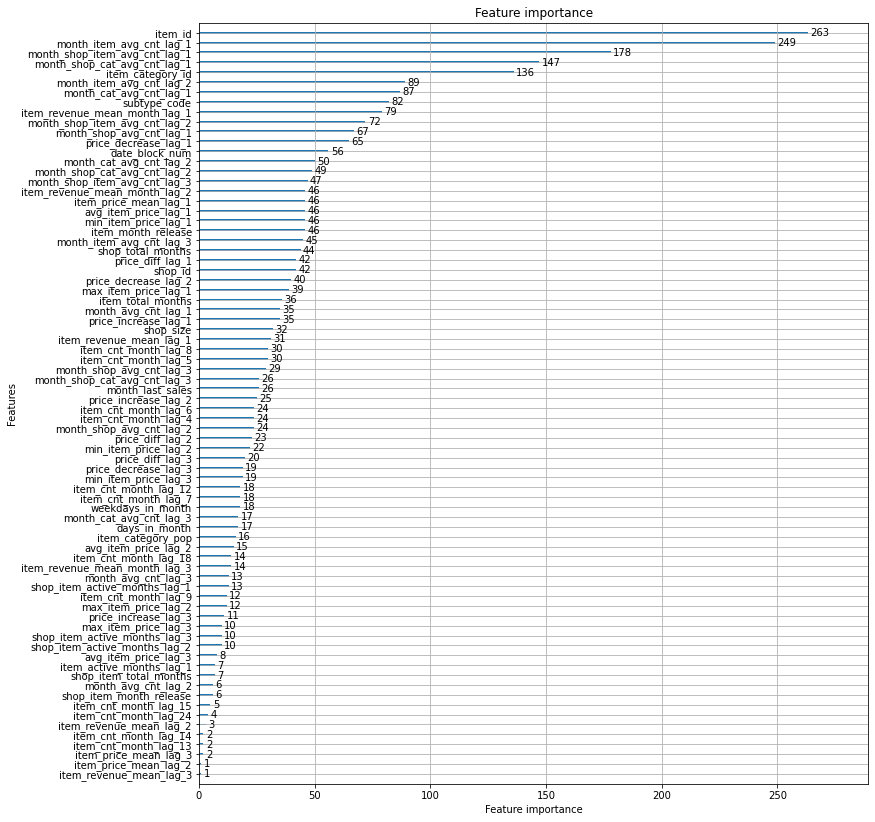

In [ ]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(lgb_model, (12, 14));

In [ ]:
# оставим признаки с важностью выше 0

new_features = list(feature_imp['Feature'][feature_imp.Value > 0])
print('All features:', len(feature_imp))
print('Features > 0:', len(feature_imp[feature_imp.Value > 0]))

X_train_imp = X_train[new_features]
X_valid_imp = X_valid[new_features]
X_test_imp = X_test[new_features]

All features: 105
Features > 0: 76


In [ ]:
# подберем основные параметры и посмотрим на графики rmse
# количество деревьев

n_trees = [10, 25, 50, 100, 200, 300, 400, 500]
rmse = []

for n in n_trees:
    lgb_model = LGBMRegressor(n_estimators=n, n_jobs=-1)
    lgb_model.fit(X_train_imp, y_train)
    y_valid_pred = lgb_model.predict(X_valid_imp).clip(0, 20)
    rmse.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred)))

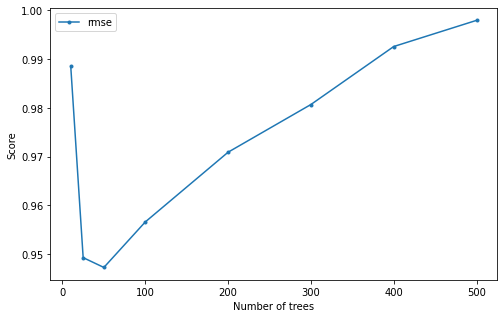

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(n_trees, rmse, marker='.', label='rmse')
plt.xlabel('Number of trees')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
lgb_n_trees = list(zip(n_trees, rmse))
lgb_n_trees

[(10, 0.9885451528918128),
 (25, 0.9492899738800541),
 (50, 0.947276049667187),
 (100, 0.9566095046291495),
 (200, 0.9709157759715015),
 (300, 0.9806989736912249),
 (400, 0.9925935595163888),
 (500, 0.9979613295445505)]

In [ ]:
# глубина деревьев

depth = list(range(1, 30, 2))
n_trees = 50
rmse = []
for d in depth:
    lgb_model = LGBMRegressor(n_estimators=n_trees, max_depth=d, n_jobs=-1)
    lgb_model.fit(X_train_imp, y_train)
    y_valid_pred = lgb_model.predict(X_valid_imp).clip(0, 20)
    rmse.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred)))

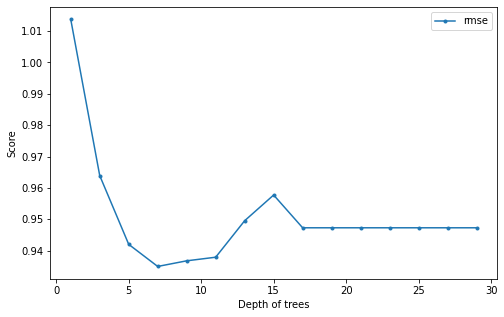

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(depth, rmse, marker='.', label='rmse')
plt.xlabel('Depth of trees')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
lgb_depth = list(zip(depth, rmse))
lgb_depth

[(1, 1.0137578636388203),
 (3, 0.9639198215841924),
 (5, 0.9419930783927654),
 (7, 0.9349448693456943),
 (9, 0.9367390619525032),
 (11, 0.9378901651991498),
 (13, 0.9495293319735404),
 (15, 0.9577293081753001),
 (17, 0.947276049667187),
 (19, 0.947276049667187),
 (21, 0.947276049667187),
 (23, 0.947276049667187),
 (25, 0.947276049667187),
 (27, 0.947276049667187),
 (29, 0.947276049667187)]

In [ ]:
# learning rate

n_trees = 50
depth = 7
learning_rate = list(np.arange(0.01, 0.2, 0.02))
rmse = []
for r in learning_rate:
    lgb_model = LGBMRegressor(learning_rate=r, n_estimators=n_trees, max_depth=depth, n_jobs=-1)
    lgb_model.fit(X_train_imp, y_train)
    y_valid_pred = lgb_model.predict(X_valid_imp).clip(0, 20)
    rmse.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred)))

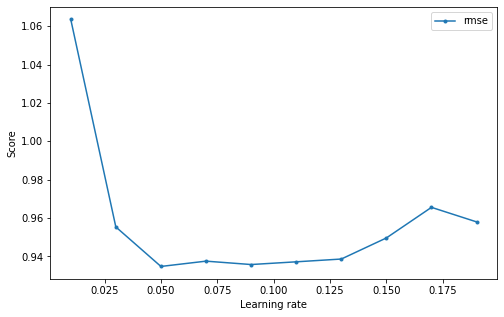

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(learning_rate, rmse, marker='.', label='rmse')
plt.xlabel('Learning rate')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
lgb_lr = list(zip(learning_rate, rmse))
lgb_lr

[(0.01, 1.0635589121551647),
 (0.03, 0.9553192646261047),
 (0.049999999999999996, 0.9347226969998141),
 (0.06999999999999999, 0.9374843248792836),
 (0.08999999999999998, 0.9357204575746682),
 (0.10999999999999997, 0.9371352106634855),
 (0.12999999999999998, 0.9385864256023292),
 (0.15, 0.9495785469479704),
 (0.16999999999999998, 0.9655364433395808),
 (0.18999999999999997, 0.9579606438886344)]

In [ ]:
# num_leaves

n_trees = 50
depth = 7
learning_rate = 0.05
num_leaves= np.arange(50, 150, 10)
rmse = []
for n in num_leaves:
    lgb_model = LGBMRegressor(learning_rate=learning_rate, n_estimators=n_trees, max_depth=depth, num_leaves=n, n_jobs=-1)
    lgb_model.fit(X_train_imp, y_train)
    y_valid_pred = lgb_model.predict(X_valid_imp).clip(0, 20)
    rmse.append(np.sqrt(mean_squared_error(y_valid, y_valid_pred)))

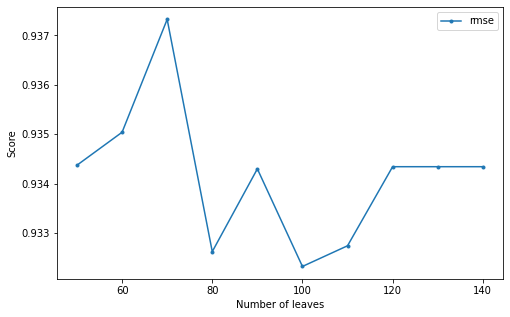

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(num_leaves, rmse, marker='.', label='rmse')
plt.xlabel('Number of leaves')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
lgb_ln = list(zip(num_leaves, rmse))
lgb_ln

[(50, 0.9343740456311189),
 (60, 0.9350400477997801),
 (70, 0.9373224375313034),
 (80, 0.9326263834609633),
 (90, 0.9342996339351421),
 (100, 0.9323268808358839),
 (110, 0.9327448789802187),
 (120, 0.93434349728778),
 (130, 0.93434349728778),
 (140, 0.93434349728778)]

In [ ]:
# подберем остальные параметры с помощью grid search
# min_child_samples, min_child_weight

lgb_model = LGBMRegressor()

params = {'learning_rate': [0.05], 
          'n_estimators': [50], 
          'max_depth': [7], 
          'num_leaves': [100], 
          'min_child_samples': np.arange(10, 200, 25),
          'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 1e1]}

gs = GridSearchCV(estimator=lgb_model, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train_imp, y_train)
gs.best_params_

{'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_samples': 10,
 'min_child_weight': 0.001,
 'n_estimators': 50,
 'num_leaves': 100}

In [ ]:
# subsample, colsample_bytree

params = {'learning_rate': [0.05], 
          'n_estimators': [50], 
          'max_depth': [7], 
          'num_leaves': [100], 
          'min_child_samples': [10],
          'min_child_weight': [0.001],
          'subsample': np.arange(0.1, 3, 0.2),
          'colsample_bytree': np.arange(0.1, 3, 0.2)}

gs = GridSearchCV(estimator=lgb_model, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train_imp, y_train)
gs.best_params_

{'colsample_bytree': 0.7000000000000001,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_samples': 10,
 'min_child_weight': 0.001,
 'n_estimators': 50,
 'num_leaves': 100,
 'subsample': 0.1}

In [ ]:
# reg_alpha, reg_lambda

params = {'learning_rate': [0.05], 
          'n_estimators': [50], 
          'max_depth': [7], 
          'num_leaves': [100], 
          'min_child_samples': [10],
          'min_child_weight': [0.001],
          'subsample': [0.1],
          'colsample_bytree': [0.7],
          'reg_alpha': [0, 1e-1, 1, 2, 5, 10, 50],
          'reg_lambda': [0, 1e-1, 1, 2, 5, 10, 50]}

gs = GridSearchCV(estimator=lgb_model, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train_imp, y_train)
gs.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_samples': 10,
 'min_child_weight': 0.001,
 'n_estimators': 50,
 'num_leaves': 100,
 'reg_alpha': 0.1,
 'reg_lambda': 0,
 'subsample': 0.1}

In [ ]:
# обучим модель с новыми параметрами

lgb_train = lgb.Dataset(X_train_imp, y_train)
lgb_eval = lgb.Dataset(X_valid_imp, y_valid, reference=lgb_train)

params = {'n_estimators': 50, 
          'learning_rate': 0.05, 
          'max_depth': 7, 
          'num_leaves': 100, 
          'min_child_samples': 10,
          'min_child_weight': 0.001,
          'subsample': 0.1,
          'colsample_bytree': 0.7, 
          'reg_alpha': 0.1,
          'reg_lambda': 0, 
          'metric': 'rmse'}

lgb_model = lgb.train(params, 
                      lgb_train, 
                      num_boost_round=20, 
                      valid_sets=[lgb_train, lgb_eval],  
                      early_stopping_rounds=100, 
                      verbose_eval=5)

y_train_pred = lgb_model.predict(X_train_imp).clip(0, 20)
y_valid_pred = lgb_model.predict(X_valid_imp).clip(0, 20)

rmse_val = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(rmse_val)

y_test_pred = lgb_model.predict(X_test_imp).clip(0, 20)

submission = pd.DataFrame({
    'ID': test.index,
    'item_cnt_month': y_test_pred
    })

submission.to_csv('submission_lgb_model.csv', index=False)

Training until validation scores don't improve for 100 rounds.
[5]	training's rmse: 1.19531	valid_1's rmse: 1.12734
[10]	training's rmse: 1.10465	valid_1's rmse: 1.05729
[15]	training's rmse: 1.04174	valid_1's rmse: 1.01283
[20]	training's rmse: 0.997183	valid_1's rmse: 0.978082
[25]	training's rmse: 0.96646	valid_1's rmse: 0.95874
[30]	training's rmse: 0.943507	valid_1's rmse: 0.943599
[35]	training's rmse: 0.928224	valid_1's rmse: 0.936143
[40]	training's rmse: 0.915274	valid_1's rmse: 0.93389
[45]	training's rmse: 0.905675	valid_1's rmse: 0.932164
[50]	training's rmse: 0.897724	valid_1's rmse: 0.932214
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.897724	valid_1's rmse: 0.932214
0.9322139727258696


Public / private LB scores: 0.934803 and 0.927066.

Результат на валидации немного улучшился, но на тестовой выборке ухудшился, модель с настройками по умолчанию работает лучше.

In [ ]:
# попробуем обучить модель с настройками по умолчанию, но с новыми признаками

lgb_model_2 = LGBMRegressor(n_jobs=-1)
lgb_model_2.fit(X_train_imp, y_train)
y_valid_pred = lgb_model_2.predict(X_valid_imp).clip(0, 20)

rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(rmse_valid)

y_test_pred = lgb_model_2.predict(X_test_imp).clip(0, 20)

submission = pd.DataFrame({
    'ID': test.index,
    'item_cnt_month': y_test_pred
    })

submission.to_csv('submission_lgb_model.csv', index=False)

0.9566095046291495


Public / private LB scores: 0.891713 and 0.880612.

Результат заметно улучшился.

In [ ]:
# попробуем еще сократить количество признаков

new_features_2 = list(feature_imp['Feature'][feature_imp.Value > 11])
print('All features:', len(feature_imp))
print('Features > 0:', len(feature_imp[feature_imp.Value > 11]))

X_train_imp_2 = X_train[new_features_2]
X_valid_imp_2 = X_valid[new_features_2]
X_test_imp_2 = X_test[new_features_2]

All features: 105
Features > 0: 59


In [ ]:
# обучим модель

lgb_model_3 = LGBMRegressor(n_jobs=-1)
lgb_model_3.fit(X_train_imp_2, y_train)

y_train_pred = lgb_model_3.predict(X_train_imp_2).clip(0, 20)
y_valid_pred = lgb_model_3.predict(X_valid_imp_2).clip(0, 20)

rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(rmse_valid)

y_test_pred = lgb_model_3.predict(X_test_imp_2).clip(0, 20)

submission = pd.DataFrame({
    'ID': test.index,
    'item_cnt_month': y_test_pred
    })

submission.to_csv('submission_lgb_model.csv', index=False)

0.9815984925846682


Public / private LB scores: 0.879766 / 0.868766.

Результат снова улучшился, несмотря на рост rmse на валидационной выборке!

Лучший результат получился на признаках с важностью > 11 (таких принаков 59), тестирование на других признаках не улучшило rmse, поэтому оставим этот набор.

In [ ]:
# объединим данные и посмотрим точность на графике

y_train_pred_1 = pd.DataFrame(y_train_pred, columns=['item_cnt_month_train_pred'])
y_valid_pred_1 = pd.DataFrame(y_valid_pred, columns=['item_cnt_month_y_valid_pred'])

result_train = pd.concat([X_train, pd.Series(y_train)], axis=1)
result_valid = pd.concat([X_valid, pd.Series(y_valid)], axis=1)

result_train.index = y_train_pred_1.index
result_valid.index = y_valid_pred_1.index

result_train = pd.concat([result_train, y_train_pred_1], axis=1)
result_valid = pd.concat([result_valid, y_valid_pred_1], axis=1)

In [ ]:
result_train[['date_block_num', 'item_cnt_month', 'item_cnt_month_train_pred']].head()

,date_block_num,item_cnt_month,item_cnt_month_train_pred
0,25,0.0,0.054903
1,26,0.0,0.068621
2,27,0.0,0.014185
3,28,0.0,0.022558
4,29,0.0,0.027124


In [ ]:
# сгруппируем по месяцам

result_train_true = result_train.groupby('date_block_num')['item_cnt_month'].sum()
result_train_pred = result_train.groupby('date_block_num')['item_cnt_month_train_pred'].sum()

result_valid_true = result_valid.groupby('date_block_num')['item_cnt_month'].sum()
result_valid_pred = result_valid.groupby('date_block_num')['item_cnt_month_y_valid_pred'].sum()

result_true = pd.concat([result_train_true, result_valid_true], axis=0)
result_pred = pd.concat([result_train_pred, result_valid_pred], axis=0)

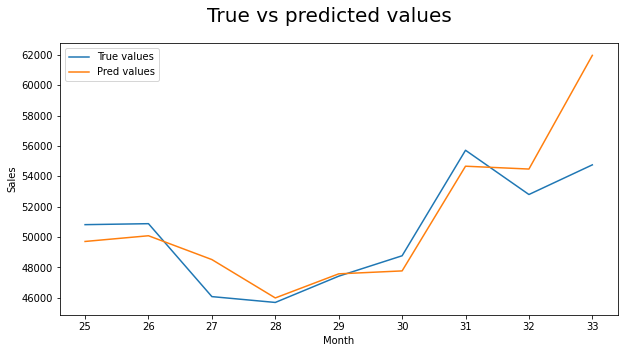

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(result_true)
plt.plot(result_pred)
plt.legend(['True values', 'Pred values'])
plt.suptitle('True vs predicted values', fontsize=20)
plt.xlabel('Month')
plt.ylabel('Sales');

## Bagging

In [ ]:
# протестируем bagging на LGBM

bagg_model = BaggingRegressor(base_estimator=LGBMRegressor())
bagg_model.fit(X_train_imp_2, y_train)

y_valid_pred = bagg_model.predict(X_valid_imp_2).clip(0, 20)

rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print(rmse_valid)

y_test_pred = bagg_model.predict(X_test_imp_2).clip(0, 20)

submission = pd.DataFrame({
    'ID': test.index,
    'item_cnt_month': y_test_pred
    })

submission.to_csv('submission_bagg_model.csv', index=False)

0.9710399224275359


Public / private LB scores: 0.885537 / 0.877619.

Результат не улучшился.

## Stacking

Архитектура:
- 1-ый уровень
  - LGBM
  - XGB
  - Catboost
  - Ridge
- 2-ой уровень
  - Linear Regression

In [ ]:
# инициализируем и обучим модели

lgb_model = LGBMRegressor(n_jobs=-1)
xgb_model = XGBRegressor(tree_method='gpu_hist', 
                         sampling_method='gradient_based', 
                         objective ='reg:squarederror')
y_train_cb = y_train.astype(np.float32)
y_valid_cb = y_valid.astype(np.float32)
cb_model = CatBoostRegressor(silent=True)
r_model = Ridge(alpha=0.01)

lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
cb_model.fit(X_train, y_train_cb)
r_model.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
# выведем предсказания моделей для валидационной и тестовой выборок

lgb_pred_valid = lgb_model.predict(X_valid).clip(0, 20)
xgb_pred_valid = xgb_model.predict(X_valid).clip(0, 20)
cb_pred_valid = cb_model.predict(X_valid).clip(0, 20)
r_pred_valid = r_model.predict(X_valid).clip(0, 20)

lgb_pred_test = lgb_model.predict(X_test).clip(0, 20)
xgb_pred_test = xgb_model.predict(X_test).clip(0, 20)
cb_pred_test = cb_model.predict(X_test).clip(0, 20)
r_pred_test = r_model.predict(X_test).clip(0, 20)

In [ ]:
# создаем новый датасет с помощью объединения предсказаний

stacked_preds_valid = np.column_stack((lgb_pred_valid, xgb_pred_valid, cb_pred_valid, r_pred_valid))
stacked_preds_test = np.column_stack((lgb_pred_test, xgb_pred_test, cb_pred_test, r_pred_test))

In [ ]:
# инициализируем мета-модель и обучим ее на объединенных предсказаниях для валидационной выборки

meta_model = LinearRegression(n_jobs=-1)
meta_model.fit(stacked_preds_valid, y_valid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
# выведем предсказания для тестовой выборки

ensemble_pred = meta_model.predict(stacked_preds_valid)

rmse_ensemble = np.sqrt(mean_squared_error(y_valid, ensemble_pred))
print(rmse_ensemble)

final_preds = meta_model.predict(stacked_preds_test)

submission = pd.DataFrame({
    'ID': test.index, 
    'item_cnt_month': final_preds
})
submission.to_csv('submission_stacked.csv', index=False)

0.9340689269740687


Your public and private LB scores are: 0.918567 and 0.911978.

Стекинг не дал улучшения.

# Итоги и сохранение лучшей модели

Лучшей моделью стал LGBMRegressor и обучение на признаках с важностью > 11.

Модель показала RMSE равный 0.879766 на Public Leaderboard и 0.868766 на Private Leaderboard.

In [ ]:
# сохранение обученной модели

trained_model = joblib.dump(lgb_model_3, 'trained_model.pkl')

# загрузка модели

load_from_joblib = joblib.load('trained_model.pkl')

# получение предсказаний для обученной модели

y_test_pred = load_from_joblib.predict(X_test_imp_2).clip(0, 20)